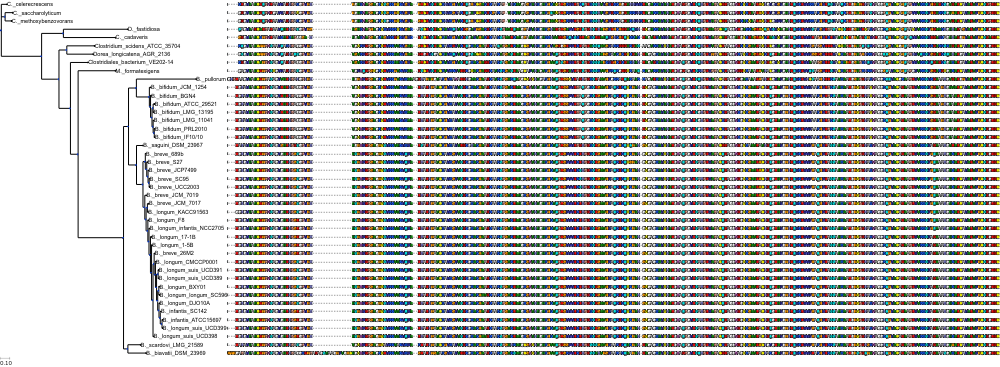

In [20]:
import ete2
import screed
from screed import ScreedDB

screed.read_fasta_sequences('Blon_1479.aln')
db = ScreedDB('Blon_1479.aln')

t = ete2.PhyloTree( 'Blon_1479.nwk', alignment='Blon_1479.aln' )

ts = ete2.TreeStyle()
ts.mode = 'r'
ts.show_leaf_name = False
ts.branch_vertical_margin = 10
ts.scale = 500

# active domain is from residues 280 to 572

for tip in t.iter_leaves() :
    seqFace = ete2.SeqMotifFace('WW', gapcolor="red")
    tip.add_face(seqFace, 0, "aligned")
    tip.sequence = tip.sequence[280:572]

t.render("%%inline", w=1000, tree_style=ts)

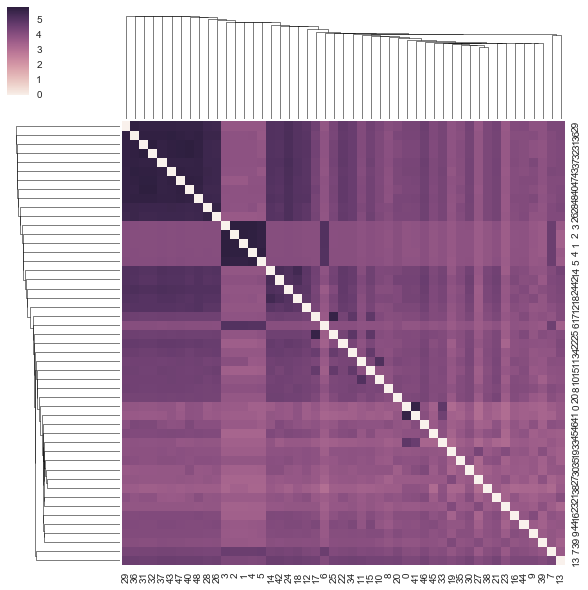

In [86]:
import json
import skbio
import numpy
import seaborn
import scipy


blosum62 = json.load( open('blosum62.json') )

sequences = []
names = []
for record in skbio.io.read( 'Similarity_RawSequences.fasta', format='fasta' ) :
    sequences.append( str(record) )
    names.append( record.metadata['id'] )

smatrix = numpy.zeros((len(sequences),len(sequences)))

for n,query in enumerate(sequences) :
    q = skbio.alignment.StripedSmithWaterman( query, substitution_matrix=blosum62 )
    for m,target in enumerate(sequences) :
        if n == m : continue
        result = q(target)
        length = result['query_end'] - result['query_begin' ]
        score = result['optimal_alignment_score'] / float(length)
        smatrix[n,m] = score
        

linkage = scipy.cluster.hierarchy.linkage( smatrix )

p = seaborn.clustermap( smatrix, row_linkage=linkage, col_linkage=linkage )

## Phylogenetic sistance matrix

Here, we compute a similarity matrix based on phylogenetic distance. Sequences
are aligned using [`clustal-omega`](http://www.clustal.org/) and a phylogeny is
constructed using [`FastTreeMP`](http://www.microbesonline.org/fasttree/). 
Citations are :

* Sievers F, Wilm A, Dineen DG, Gibson TJ, Karplus K, Li W, Lopez R, McWilliam H, Remmert M, Söding J, Thompson JD, Higgins DG (2011). *Fast, scalable generation of high-quality protein multiple sequence alignments using Clustal Omega*. Molecular Systems Biology 7:539 [http://dx.doi.org/10.1038/msb.2011.75](doi:10.1038/msb.2011.75)
* Price, M.N., Dehal, P.S., and Arkin, A.P. (2009) *FastTree: Computing Large Minimum-Evolution Trees with Profiles instead of a Distance Matrix. Molecular Biology and Evolution* 26:1641-1650, [http://dx.doi.org/10.1093/molbev/msp077](doi:10.1093/molbev/msp077).
Freely available at MBE. Or see earlier version
* Price, M.N., Dehal, P.S., and Arkin, A.P. (2010) FastTree 2 -- Approximately Maximum-Likelihood Trees for Large Alignments. PLoS ONE, 5(3):e9490. [http://dx.doi.org/10.1371/journal.pone.0009490](doi:10.1371/journal.pone.0009490).

We then re-root the tree at the midpoint (unless you want to specify an outgroup),
and build a matrix of the patristic distances.

In [106]:
!clustalo -i Similarity_RawSequences.fasta --outfmt=fasta -o Similarity_RawSequences_align.fasta
!FastTreeMP 'Similarity_RawSequences_align.fasta' > Similarity_RawSequences_align.tree

FATAL: Cowardly refusing to overwrite already existing file 'Similarity_RawSequences_align.fasta'. Use --force to force overwriting.
FastTree Version 2.1.8 SSE3, OpenMP (4 threads)
Alignment: Similarity_RawSequences_align.fasta
Amino acid distances: BLOSUM45 Joins: balanced Support: SH-like 1000
Search: Normal +NNI +SPR (2 rounds range 10) +ML-NNI opt-each=1
TopHits: 1.00*sqrtN close=default refresh=0.80
ML Model: Jones-Taylor-Thorton, CAT approximation with 20 rate categories
Initial topology in 0.13 seconds
Refining topology: 22 rounds ME-NNIs, 2 rounds ME-SPRs, 11 rounds ML-NNIs
Total branch-length 18.975 after 0.82 sec
ML-NNI round 1: LogLk = -62380.740 NNIs 8 max delta 8.69 Time 1.70
Switched to using 20 rate categories (CAT approximation)
Rate categories were divided by 0.864 so that average rate = 1.0
CAT-based log-likelihoods may not be comparable across runs
Use -gamma for approximate but comparable Gamma(20) log-likelihoods
ML-NNI round 2: LogLk = -60527.614 NNIs 3 max delta 

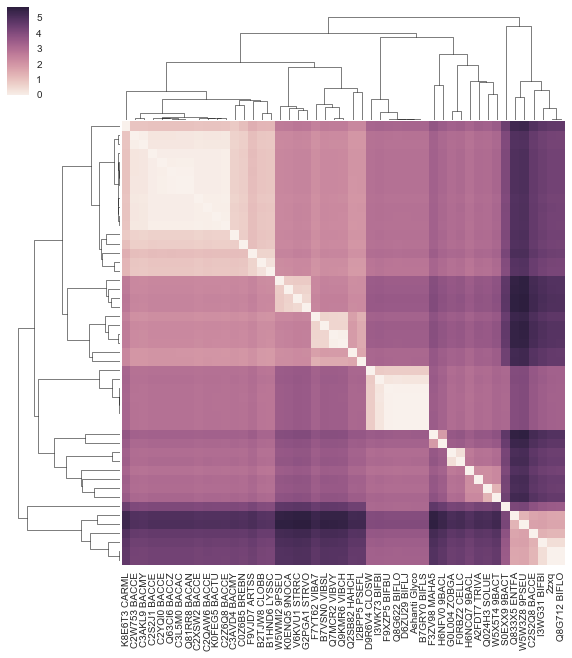

In [127]:
import skbio

pftree = skbio.tree.TreeNode.read( 'Similarity_RawSequences_align.tree' )
pftree.root_at_midpoint()
pfdm = pftree.tip_tip_distances()

linkage = scipy.cluster.hierarchy.linkage( pfdm.data )

p = seaborn.clustermap( pfdm.data, row_linkage=linkage, col_linkage=linkage, 
                        xticklabels=pfdm.ids, yticklabels=False )